In [1]:
import warnings


warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from scipy import ndimage, misc
from scipy.ndimage import generic_laplace
from tqdm import tqdm 
from skimage.morphology import binary_closing, binary_opening
from sklearn.ensemble import RandomForestClassifier
from utils_rf import *

from sklearn.metrics import f1_score
from skimage.metrics import hausdorff_distance

import pickle


In [2]:
from utils_rf import *

In [3]:
#load the model from disk
rfc1_100 = pickle.load(open('finalized_model_100px.pkl', 'rb'))

In [22]:
validation_set = [67, 107,  89, 276, 109, 199, 352,  51, 326, 165,  92, 286, 244,
                  142, 281, 132, 365, 176, 128, 333,  63, 209, 191, 164, 106,  61,
                  120, 259, 263, 146]

test_patient = 63
training_set = True

if training_set:
    brats_path = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
    dataset_part = "_Training_"
else:
    brats_path = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'
    dataset_part="_Validation_"


In [11]:
def model_prediction(patient_number,trained_classifier,dataset_part):
    """Given a trained classifier, predicts a tumour mask for a patient

    Args:
        patient_number (list[int]): Patient to predict tumour mask
        trained_classifier: classifier previously trained
        dataset_part: to select either training or validation patient

    Returns:
        f1s_predicted: F1 Score of the brain voxels
        hd_predicted: Hausdorff distance of whole volume
        pred_TM_px1_final: Final volume of predicted mask
    """
    if dataset_part == "_Training_":
        test_arr_2,true_TM_px1_BM,vox_idx,original_mask,patient_data = obtain_test_data(patient_number)
        
        pred_TM_px1_BM = trained_classifier.predict(test_arr_2)
        
        f1s_predicted = f1_score(true_TM_px1_BM,pred_TM_px1_BM)
        
        #Predicted volume reconstruction
        pred_TM_px1_final = np.zeros((240,240,155))
        for pred_idx,pred in enumerate(pred_TM_px1_BM):
            pred_TM_px1_final[vox_idx[pred_idx][0],vox_idx[pred_idx][1],vox_idx[pred_idx][2]] = pred
        
        hd_predicted = hausdorff_distance(original_mask,pred_TM_px1_final)

        return f1s_predicted,hd_predicted,pred_TM_px1_final,patient_data
    else:
        test_arr_2,vox_idx,patient_data = obtain_validation_data(patient_number)
        pred_TM_px1_BM = trained_classifier.predict(test_arr_2)

        #Predicted volume
        pred_TM_px1_final = np.zeros((240,240,155))
        for pred_idx,pred in enumerate(pred_TM_px1_BM):
            pred_TM_px1_final[vox_idx[pred_idx][0],vox_idx[pred_idx][1],vox_idx[pred_idx][2]] = pred
            return pred_TM_px1_final,patient_data

In [12]:
test_results = pd.read_csv('final_results.csv', index_col=0).sort_values('rand_forest_dsc')
test_results['rand_forest_dsc']

patients
128    0.000000
63     0.208941
191    0.248114
92     0.286916
244    0.359583
109    0.399039
209    0.451330
106    0.464761
286    0.493306
120    0.522137
67     0.530236
365    0.552296
142    0.552626
89     0.557593
146    0.560862
164    0.587883
61     0.625054
107    0.648267
352    0.652776
176    0.655292
51     0.728836
281    0.739010
276    0.742456
326    0.775347
259    0.807557
132    0.818768
263    0.838376
333    0.852734
199    0.888991
165    0.921417
Name: rand_forest_dsc, dtype: float64

In [23]:
f1s_pred,hd_pred,result_mask,patient_data = model_prediction([test_patient],rfc1_100,dataset_part)

In [24]:
f1s_pred

0.20894142508089547

In [27]:
result_mask_mm = binary_closing(binary_opening(result_mask))

In [28]:
print("Dice score: ", dice_score(result_mask_mm, patient_data[0,0]))
print("Hausdorf distance: ", hausdorff_distance(result_mask_mm, patient_data[0,0]))

Dice score:  0.11540075535039866
Hausdorf distance:  19.0


In [10]:
np.shape(patient_data[0][0])

(240, 240, 155)

In [25]:
print("Dice score: ", dice_score(result_mask, patient_data[0,0]))
print("Hausdorf distance: ", hausdorff_distance(result_mask, patient_data[0,0]))

Dice score:  0.20894142508089547
Hausdorf distance:  63.655321851358195


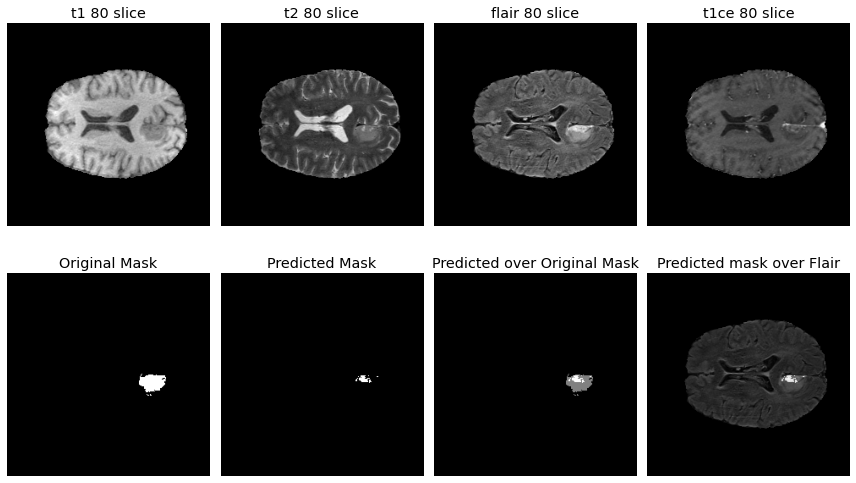

In [30]:
plt.style.use('ggplot')
plot_results(patient_data, result_mask, 80)

In [6]:
result_mask,patient_data = model_prediction([50],rfc1_100,dataset_part)

  0%|          | 0/1516132 [00:00<?, ?it/s]


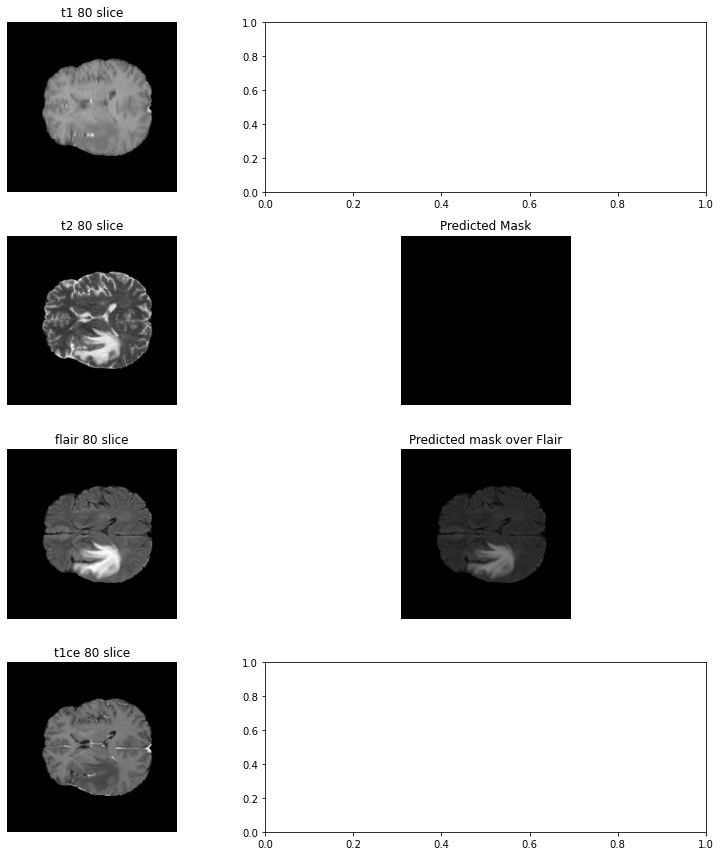

In [8]:
plot_validation_results(patient_data,result_mask,80)